In [1]:
import pandas as pd
import numpy as np
import os
import getpass
import re
import nltk
import tqdm
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import swifter
import matplotlib as plt
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras import optimizers

In [2]:
dff = pd.read_csv("Merged_Finall.csv")
dff = dff[dff["Date"] > "2014-01-01"]
temp_dff = dff
dff = dff[["Close", "Open","Volume", "High"]]


scaler = StandardScaler()
scaler = scaler.fit(dff)
scaled_df = scaler.transform(dff)

training_ds = scaled_df[:(int(len(scaled_df) * 0.8))]
test_ds = scaled_df[(int(len(scaled_df) * 0.8)):]

print(f"training dataset contains {len(training_ds)} samples and test dataset contains {len(test_ds)} samples")


training_ds_temp = temp_dff[:(int(len(temp_dff) * 0.8))]
test_ds_temp = temp_dff[(int(len(temp_dff) * 0.8)):]

train_dates = pd.to_datetime(training_ds_temp['Date'])
test_dates = pd.to_datetime(test_ds_temp['Date'])

training dataset contains 1721 samples and test dataset contains 431 samples


In [3]:
def sliding_windows(dataset, future, lookback, label_col):
    
    Features = []
    label = []

    n_future = future 
    n_past = lookback

    for i in range(n_past, len(dataset) - n_future +1):
        Features.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        label.append(dataset[i + n_future - 1:i + n_future, label_col]) #0 means our label class in 1st column.

    Features, label = np.array(Features).astype(np.float32), np.array(label).astype(np.float32)

    print('Features shape == {}.'.format(Features.shape))
    print('label shape == {}.'.format(label.shape))

    return Features, label

In [4]:
future_ = 1
lookback_ = 4

train_ds_windows_X, train_ds_windows_y  = sliding_windows(training_ds, future_, lookback_, 0)
test_ds_windows_X, test_ds_windows_y  = sliding_windows(test_ds, future_, lookback_, 0)

Features shape == (1717, 4, 4).
label shape == (1717, 1).
Features shape == (427, 4, 4).
label shape == (427, 1).


In [5]:
model = Sequential()
model.add(LSTM(500, input_shape=(train_ds_windows_X.shape[1], train_ds_windows_X.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_ds_windows_y.shape[1]))


model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

2021-12-12 14:29:50.321288: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500)               1010000   
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 501       
Total params: 1,010,501
Trainable params: 1,010,501
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100


2021-12-12 14:29:50.697811: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-12 14:29:50.718232: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


11/11 [==============================] - 1s 54ms/step - loss: 0.1869 - val_loss: 0.4035
Epoch 2/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0197 - val_loss: 0.1448
Epoch 3/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0071 - val_loss: 0.1414
Epoch 4/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0043 - val_loss: 0.0743
Epoch 5/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 0.0733
Epoch 6/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0016 - val_loss: 0.0582
Epoch 7/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0568
Epoch 8/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 0.0568
Epoch 9/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0589
Epoch 10/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0581
Epoch 11/10

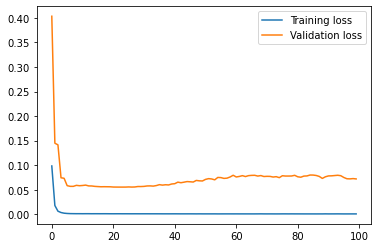

In [6]:
history = model.fit(train_ds_windows_X, train_ds_windows_y, epochs=100, batch_size=128, validation_split=0.2, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [7]:
prediction = model.predict(test_ds_windows_X)

In [8]:
prediction_copies = np.repeat(prediction, test_ds.shape[1], axis=-1)
true_predictions = scaler.inverse_transform(prediction_copies)[:,0]

print(f"The shape of predictions is {true_predictions.shape}")

The shape of predictions is (427,)


In [9]:
df_forecast = pd.DataFrame({'Date':np.array(test_dates[lookback_:]), 'Predictions':true_predictions.flatten(), 'Actual':test_ds_temp[lookback_:]["Close"]})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [10]:
df_forecast

,Date,Predictions,Actual
1973,2018-09-23,6535.417480,6710.630000
1974,2018-09-24,6556.080078,6595.410000
1975,2018-09-25,6519.005859,6446.470000
1976,2018-09-26,6517.176758,6495.000000
1977,2018-09-27,6454.677734,6676.750000
...,...,...,...
2395,2019-11-19,8488.943359,8206.145918
2396,2019-11-20,8539.808594,8027.268243
2397,2019-11-21,8346.115234,7642.749945
2398,2019-11-22,8183.743164,7296.577568


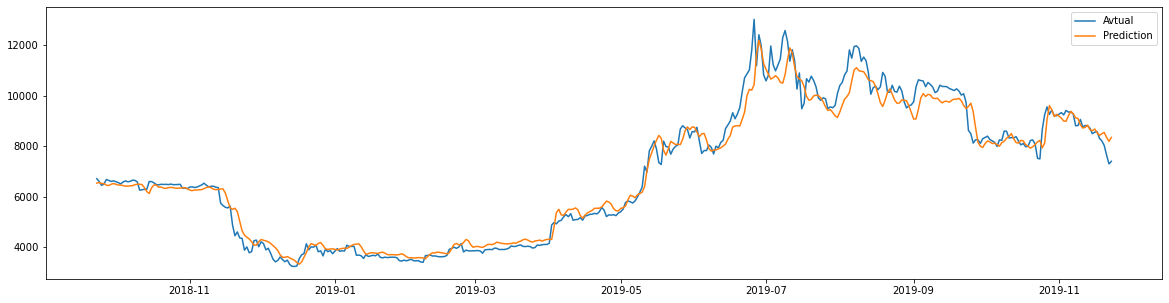

In [11]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(df_forecast['Date'], df_forecast['Actual'], label = "Avtual")
plt.plot(df_forecast['Date'], df_forecast['Predictions'], label = "Prediction")
plt.legend()

In [12]:
merged_df = df_forecast

In [16]:
merged_df["Actual_prev"] = merged_df["Actual"].shift(+1)
merged_df["Pred_prev"] = merged_df["Predictions"].shift(+1)
merged_df = merged_df.dropna()

merged_df['Actual_target'] = merged_df[['Actual','Actual_prev']].apply(lambda x: 1 if x.Actual > x.Actual_prev else 0, axis=1)
merged_df['Pred_target'] = merged_df[['Predictions','Pred_prev']].apply(lambda x: 1 if x.Predictions > x.Pred_prev else 0, axis=1)

act = list(merged_df["Actual_target"])
pred = list(merged_df["Pred_target"])

hit = 0
miss = 0
for i in range(len(act)):
    if act[i] == pred[i]:
        hit+=1
    else:
        miss+=1
print(f"total hits are {hit} and total misses are {miss}")

total hits are 223 and total misses are 201
